In [1]:
from operator import mul
import urllib2
import numpy as np
im_shape = (480, 640, 3)
im_sz = reduce(mul, im_shape)

def from_buffer(im_str):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape((480, 640, 3))    
    
def get_images():
    response=urllib2.urlopen('http://localhost:8889/camera')
    left = from_buffer(response.read(im_sz))
    right = from_buffer(response.read(im_sz))
    response.close()
    return left, right

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt


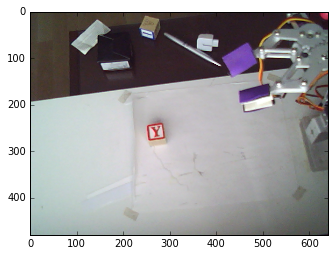

In [3]:
left_im, right_im = get_images()

plt.imshow(right_im)

In [ ]:
plt.imshow(right_im)

In [ ]:
import json
def get_ps3_out():
    response=urllib2.urlopen('http://localhost:8888/get')
    js, buttons = json.loads(''.join(response.readlines()))
    pressed_buttons = []
    for (button, state) in js.items():
        if state > 0.5:
            pressed_buttons.append(button)
        if state < -0.5 and button == '1':
            pressed_buttons.append('0')
            
    for (button, state) in buttons.items():
        if state > 0.5:
            pressed_buttons.append(button)
    return pressed_buttons

In [ ]:
get_ps3_out()

In [97]:
motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}

import time
def move_robot():
    url = 'http://localhost:8889/robot/%d/%d/%d/%d/%d/%d/'
    ms = [l[1] for l in sorted(motor_state.items(), key=lambda x: x[0])]
    call_url = url%tuple(ms)
    print call_url
    time.sleep(0.1)
    response = urllib2.urlopen(call_url)
    return response.readlines()

def update_state(motor_id, update_direction):
    motor_state[motor_id] = motor_state[motor_id] + 50*update_direction
    move_robot()
    
move_robot()    

http://localhost:8889/robot/1500/1500/1500/1500/1500/1500/


[]

In [ ]:
button_motor_map = {"0": [0, -1], "1": [0, +1], 
                    "2": [1, -1], "3": [1, +1],
                    "8": [2, -1], "10":[2, +1],
                    "9": [3, -1], "11":[3, +1],
                    "4": [4, -1], "6": [4, +1],
                    "14":[5, -1], "12":[5, +1]}


In [ ]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def save_state(writer, left_im, right_im, motor, direction, motor_state):
l 

def save_record(writer):
    writer.close()

In [ ]:
import tensorflow as tf

episode_save_location = '/data/robotics/pick_episodes/'

In [ ]:
episode = 10

In [ ]:
pi =  tf.python_io.TFRecordWriter(
"%s_%d.tfrecords"%(episode_save_location, episode))


try:
    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map.get(press,[None, None])
            if motor is None:
                continue
            left_im, right_im = get_images()
            
            save_state(pi, left_im, right_im, motor, direction, motor_state)
            update_state(motor, direction)
finally:
    episode+=1
    save_record(pi)
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    print episode
    

In [ ]:
print episode

In [ ]:
pi = tf.python_io.tf_record_iterator("%s_%d.tfrecords"%
                                     (episode_save_location, 0))
example = tf.train.Example()
example.ParseFromString(pi.next())


In [ ]:
li = example.features.feature['right_image']

im = li.bytes_list.value[0]

left = np.fromstring(im, dtype=np.uint8).reshape((480,640,3))

plt.imshow(left)

In [ ]:
pi.close()

In [5]:
import sys
import tensorflow as tf
sys.path.append('/home/karthik/code/pyrobo/network_models/')
from multicam_net import PurchasePredNet

In [6]:
net = PurchasePredNet()


sess = tf.Session()


In [7]:
saver = tf.train.Saver()

In [8]:
sess.run(tf.global_variables_initializer())

In [9]:
saver.restore(sess, '/data/robotics/models/pick_episodes/25000_iters')

In [96]:
import cv2
def rs(arr):
    return cv2.resize(arr, (224, 224)).reshape((1, 224, 224, 3))
left_im, right_im = [rs(x) for x in get_images()]

out_pred = sess.run(tf.nn.softmax(net.layers['out']), { net.left_img:left_im,
                                                    net.right_img: right_im} )

print(out_pred)
choice = np.argmax(out_pred)

motor = choice/2
direction = choice%2*2-1
print(motor, direction)
update_state(motor, direction)
# def extract_motor_direction(choice)

[[  1.35542331e-02   3.08641709e-28   0.00000000e+00   3.68533235e-19
    0.00000000e+00   1.79145331e-06   7.27459910e-32   2.79227376e-35
    2.01558694e-03   0.00000000e+00   9.84428406e-01   3.31481215e-17]]
(5, -1)
http://localhost:8889/robot/1500/2050/1750/1500/1100/1450/
